Set up environment
----

In [2]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline
import new_colormaps as cm

import os
import sys
import itertools as it
import warnings
import itertools

import pyemma
pyemma.__version__

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

warnings.filterwarnings("ignore", category=DeprecationWarning)

#import shapely.geometry as geo

Useful functions
----

In [3]:
def cosd(deg):
    return np.cos(deg/180. * np.pi)

def sind(deg):
    return np.sin(deg/180. * np.pi)

def xyz2fracM(crystal_prms):
    a = crystal_prms['a']
    b = crystal_prms['b']
    c = crystal_prms['c']
    alpha = crystal_prms['alpha']
    beta = crystal_prms['beta']
    gamma = crystal_prms['gamma']
    v = np.sqrt(1-cosd(alpha)**2-cosd(beta)**2-cosd(gamma)**2 + 2*cosd(alpha)* cosd(beta)*cosd(gamma))
    r1 = [1./a, -cosd(gamma)/a/sind(gamma), (cosd(alpha)*cosd(gamma)-cosd(beta)) / a/v/sind(gamma)]
    r2 = [0, 1./b/sind(gamma), (cosd(beta)*cosd(gamma)-cosd(alpha)) / b/v/sind(gamma)]
    r3 = [0, 0, sind(gamma)/c/v]
    M = np.array([r1, r2, r3])
    return M

def frac2xyzM(crystal_prms):
    a = crystal_prms['a']
    b = crystal_prms['b']
    c = crystal_prms['c']
    alpha = crystal_prms['alpha']
    beta = crystal_prms['beta']
    gamma = crystal_prms['gamma']
    v = np.sqrt(1-cosd(alpha)**2-cosd(beta)**2-cosd(gamma)**2 + 2*cosd(alpha)* cosd(beta)*cosd(gamma))
    r1 = [a, b*cosd(gamma), c*cosd(beta)]
    r2 = [0, b*sind(gamma), c*(cosd(alpha)-cosd(beta)*cosd(gamma))/sind(gamma)]
    r3 = [0, 0, c*v/sind(gamma)]
    M = np.array([r1, r2, r3])
    return M

def wrap(x, y, z, Mfwd, Mrev):
    fxyz = np.dot(Mfwd, np.array([x, y, z]))
    fxyz_ = fxyz % 1
    wrapped = np.dot(Mrev, np.array(fxyz_))
    wrapped = np.around(wrapped, 8)
    return wrapped 


# # Function to read the dump file

def read_file(infiles, frames):
    t = []
    xyz = []
    for infile in infiles:
        with open(infile, 'r') as fin:
            for line in fin:
              if len(t)<=frames:
                line_chunks = line.split()
                if line_chunks[0] != '#':
                    try:
                        ind, x, y, z = map(float, line_chunks)
                        ind = int(line_chunks[0])
                        xyz.append([x, y, z])
                    except:
                        simtime, N = map(int, line_chunks)
                        t.append(float(simtime))

    # Convert timestep to time
    #fs2ps = 0.001
    #t = (np.array(t) - t[0]) * timestep_fs * fs2ps

    # Get number of frames and reshape data array
    numframes =  len(xyz) // N
    xyz = np.reshape(xyz, (numframes, N, 3))

    if debug:
        print ("Finished read_file")
    return numframes, N, 3, xyz


def wrapcoords(alldata, Mfwd, Mrev):
    N, trj, dim = np.shape(alldata)
    alldataT= np.transpose(alldata)
    xyz_wrap_T = np.empty((dim, trj, N))
    for i in range(trj):
        frac_T = np.dot(Mfwd, alldataT[:,i,:])
        
        ## offset unit cell
        #frac_T += np.transpose([[.5, .5, 0]])
        
        # wrap unit cell coordinates
        frac_wrap_T = frac_T % 1

        # convert fractional to cartesian coords
        xyz_wrap_T[:, i, :] = np.dot(Mrev, frac_wrap_T)

    xyz_wrap = np.transpose(xyz_wrap_T)
    
    #if debug:
    #    print ("finished wrapcoords")
    return xyz_wrap

Read dumpfile to obtain data
----

In [4]:
debug = True
timestep_fs = 1

adsorbate = 'butane'
trjs = 260  # 200, 260, 270
T = 298
Nframes = 4000
dt = .001  # convert frame indices to ns


### ABENAKI
basedir = '/home/vargaslo/ws/LAMMPS_MD/MSD_analyzed/298K'
sourcedir = os.path.join(basedir, '{}/{}/MDSim_{}K'.format(adsorbate, trjs, T))

### ANISHINAABE
sourcedir=''


dumpfile = os.path.join(sourcedir, 'lammps_3_extend.dump')
Nframes, _, Ndims, mydat_u_orig = read_file([dumpfile], Nframes)
print (np.shape(mydat_u_orig))

activedir = os.path.join('{}_N{}_T{}_ff{}'.format(adsorbate, trjs, T, Nframes))
if not os.path.exists(activedir):
    os.makedirs(activedir)


crystal = {}
crystal['a'] = 39.97
crystal['b'] = 40.00
crystal['c'] = 16.58*2
crystal['alpha'] = 90
crystal['beta'] = 90
crystal['gamma'] = 120



Finished read_file
(4000, 260, 3)


In [5]:
class data:
    def __init__(self, origdata, crystal_prms):
        self.origdata = origdata
        self.crystal_prms = crystal_prms        
        self.Mfwd = xyz2fracM(crystal_prms)
        self.Mrev = frac2xyzM(crystal_prms)      
        self.Nframes, self.Ntrjs, self.Ndims = np.shape(self.origdata)
    
    def unwrapped(self):
        return self.origdata
    
    def wrapped(self):
        return wrapcoords(self.origdata, self.Mfwd, self.Mrev)

    #-------------------------------------------------
    # create list of ndarrays(trjs,dims) using indices
    #-------------------------------------------------

    def get_xyz_region(self, hexregions=1):  # hexregions=1 is to split meso/micro
        xyz = self.unwrapped()
        xyz_wrap = self.wrapped()

        # check if inside circle
        P1 = np.dot(self.Mrev, np.array([0.0, 0.0, 0]))   #   P4------P8-------P3
        P2 = np.dot(self.Mrev, np.array([1.0, 0.0, 0]))   #    \        \        \
        P3 = np.dot(self.Mrev, np.array([1.0, 1.0, 0]))   #     \   uc   \   uc   \
        P4 = np.dot(self.Mrev, np.array([0.0, 1.0, 0]))   #      \        \        \
        P5 = np.dot(self.Mrev, np.array([0.0, 0.5, 0]))   #       P5-------P7------P9
        P6 = np.dot(self.Mrev, np.array([0.5, 0.0, 0]))   #        \        \        \
        P7 = np.dot(self.Mrev, np.array([0.5, 0.5, 0]))   #         \   uc   \   uc   \
        P8 = np.dot(self.Mrev, np.array([0.5, 1.0, 0]))   #          \        \        \
        P9 = np.dot(self.Mrev, np.array([1.0, 0.5, 0]))   #           P1-------P6------P2

        region = np.ones((self.Nframes, self.Ntrjs, 1), dtype=int)  # default to region 1 (micro)
                                                                    # region 2 is meso outer, and so on until hexregions+1

        for i in range(hexregions):
            radius = 17 * np.sqrt(1 - 1.*i/hexregions)
            for P in [P1, P2, P3, P4]:
                s2 = np.sum(np.power(xyz_wrap - P, 2)[:,:,0:2], axis=2)
                region[:,:, 0] +=  (s2 <= radius**2)*1  # regions are numbered increasing to the center of channel

        #combined = np.concatenate((xyz, region, xyz_wrap), axis=2)
        reg1 = region==1
        reg2 = region==2
        
        microxyz_w = xyz_wrap*reg1
        mesoxyz_w = xyz_wrap*reg2
    
        combined = np.concatenate((xyz, region, microxyz_w), axis=2)

        return combined

        
    def group_ind(self):
        xyzdata = self.get_xyz_region()
        indices = {}
        indices[1] = []
        indices[2] = []
            
        first = 0
        last = 0
        for p in range(self.Ntrjs):
            for i,v in enumerate(itertools.groupby(xyzdata[:,p,:], lambda x: x[3])):
                key, group = v
                N = len(list(group))
                last = first + N
                indices[int(key)].append((first, last))
            
                first = last
        return indices


    def micro_u(self, region=1):
        xyz = self.unwrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data

    def micro_w(self, region=1):
        xyz = self.wrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data

    def meso_u(self, region=2):
        xyz = self.unwrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data
        
    def meso_w(self, region=2):
        xyz = self.wrapped()
        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
            tmp = xyz_[ff:lf, :]
            data.append(tmp)
        return data

    def xyz2sz(self):
        xyz = self.wrapped()
        # check if inside circle
        P1 = np.dot(self.Mrev, np.array([0.0, 0.0, 0]))   #   P4------P8-------P3
        P2 = np.dot(self.Mrev, np.array([1.0, 0.0, 0]))   #    \        \        \
        P3 = np.dot(self.Mrev, np.array([1.0, 1.0, 0]))   #     \   uc   \   uc   \
        P4 = np.dot(self.Mrev, np.array([0.0, 1.0, 0]))   #      \        \        \
        P5 = np.dot(self.Mrev, np.array([0.0, 0.5, 0]))   #       P5-------P7------P9
        P6 = np.dot(self.Mrev, np.array([0.5, 0.0, 0]))   #        \        \        \
        P7 = np.dot(self.Mrev, np.array([0.5, 0.5, 0]))   #         \   uc   \   uc   \
        P8 = np.dot(self.Mrev, np.array([0.5, 1.0, 0]))   #          \        \        \
        P9 = np.dot(self.Mrev, np.array([1.0, 0.5, 0]))   #           P1-------P6------P2


        s1 = np.sqrt(np.sum((xyz[:,:,0:2]-P1[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s2 = np.sqrt(np.sum((xyz[:,:,0:2]-P2[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s3 = np.sqrt(np.sum((xyz[:,:,0:2]-P3[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s4 = np.sqrt(np.sum((xyz[:,:,0:2]-P4[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s0 = np.minimum(s1, s2)
        s0 = np.minimum(s0, s3)
        s0 = np.minimum(s0, s4)

        # find points in microchannel
        tmp = s0>17
        
        s = tmp*s0
        z = tmp*xyz[:,:,2]

        sz = np.zeros((self.Nframes, self.Ntrjs, 2))
        sz[:,:,0] = s
        sz[:,:,1] = z
        
        return sz
    
    def tica_sz(self, region=1):  # region 1 is microchannel
        sz = self.xyz2sz()
        sz_ = np.reshape(sz, (self.Nframes * self.Ntrjs, 2), order='F')
        
#        xyz = self.wrapped()
#        xyz_ = np.reshape(xyz, (self.Nframes * self.Ntrjs, self.Ndims), order='F')
        data = []
        for i in self.group_ind()[region]:
            ff, lf = i
#            tmp = xyz_[ff:lf, :]
            tmp = sz_[ff:lf, :]
#            tmp2 = np.zeros((np.shape(tmp)[0], 2))
#            tmp2[:,0] = np.sqrt(tmp[:,0]**2 + tmp[:,1]**2)
#            tmp2[:,1] = tmp[:,2]
            data.append(tmp)
            
#        return list(np.swapaxes(sz, 0, 1))
        return data
        

x = data(mydat_u_orig, crystal)


In [6]:
# use this to visualize data
if 0:
    plt.close('all')
    for i in x.tica_sz():
        plt.plot(i[:,0], i[:,1], ls='', marker=',')
    
    plt.gca().set_aspect('equal')
    plt.show()
    
print (len(x.tica_sz()))

12466


In [28]:
Y = x.tica_sz()

def longest(Y):
    # get index of longest trajectory
    longest = 0
    for i,v in enumerate(Y):
        currentlen = len(v)
        currentind = i
        if currentlen>longest:
            longest = currentlen
            index = currentind
    return index, longest

maxduration_ind, maxduration = longest(Y)
print (maxduration, maxduration_ind)


if 0:  # Show free energy?
    plt.close('all')
    pyemma.plots.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap=cm.viridis)
    
    plt.gca().set_aspect('equal')
    plt.xlabel('Distance from mesochannel axis (A)')
    plt.ylabel('Z-distance (A)')
    plt.show()

(4000, 2181)


Discretize trajectories
----

In [29]:
n_clusters = 512

stride = max(1, (Nframes*trjs)//100000)
print ('stride ', stride)

clustering = coor.cluster_kmeans(Y, k=n_clusters, max_iter=200, stride=stride, fixed_seed=True)
dtrajs = clustering.dtrajs

('stride ', 10)
19-04-16 09:14:02 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     Cluster centers converged after 5 steps.


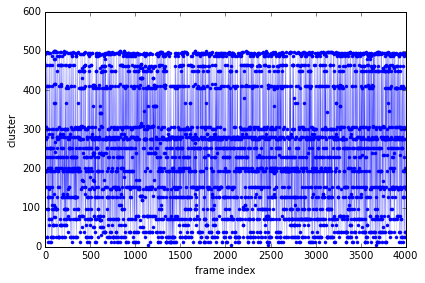

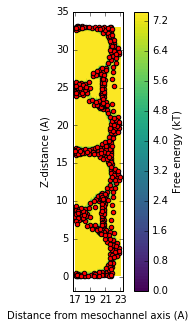

In [41]:
def dtraj_fig(dtrajs):
    
    # show discrete trajectory time series
    plt.close('all')
    plt.figure()
    plt.plot(dtrajs[maxduration_ind], marker='.', ls='-', lw=.1)
    plt.ylabel('cluster')
    plt.xlabel('frame index')
    plt.tight_layout()
    
    
    plt.figure(figsize=(4,5))
    pyemma.plots.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap=cm.viridis)
    plt.gca().set_aspect('equal')
    plt.xlabel('Distance from mesochannel axis (A)')
    plt.ylabel('Z-distance (A)')
    plt.xticks([17,19,21,23])
    plt.scatter(clustering.clustercenters[:,0], clustering.clustercenters[:,1], c='r')

    plt.savefig('{}/dtrj0_{}.png'.format(activedir, n_clusters), dpit=144)
    
    return

dtraj_fig(dtrajs)

Implied timescales
----

In [42]:
its = msm.timescales_msm(dtrajs, nits=7, n_jobs=-1, lags=np.linspace(1, maxduration/3, 4, dtype=int))

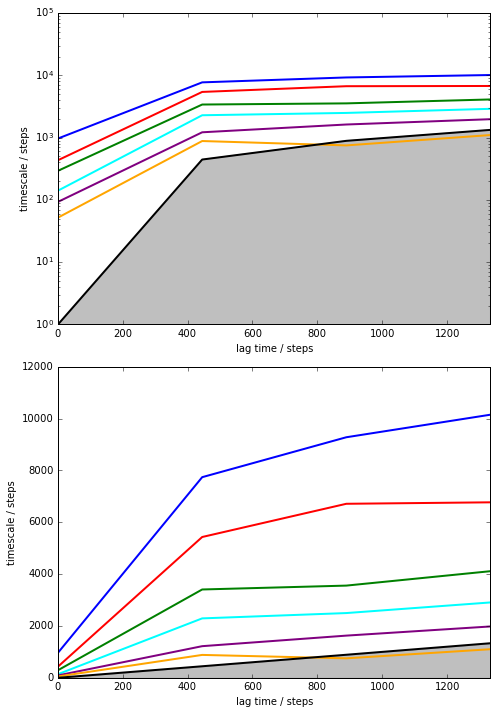

In [43]:
plt.close('all')
plt.figure(figsize=(7,10))

plt.subplot(211)
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)

plt.subplot(212)
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)

plt.tight_layout()
plt.savefig('{}/its_{}.png'.format(activedir, n_clusters), dpi=144)
#plt.show()

MSM
----

In [56]:
msm_lag = Nframes//3
msm_lag = 10

M = msm.estimate_markov_model(dtrajs, msm_lag, sparse=False)
print (msm_lag)

10


In [57]:
print ('fraction of states used = ', M.active_state_fraction)
print ('fraction of counts used = ', M.active_count_fraction)

def mapcc(M):
    out = {}
    for i,v in enumerate(M.largest_connected_set):
        out[i] = {}
        out[i]['orig'] = v
        out[i]['cc'] = clustering.clustercenters[v]
    return out

mapped = mapcc(M)


('fraction of states used = ', 1.0)
('fraction of counts used = ', 1.0)


In [58]:
# test MSM
M = msm.bayesian_markov_model(dtrajs, msm_lag, nsamples=100)  # default nsamples is 100

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


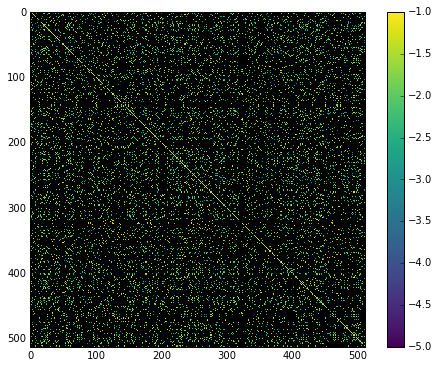

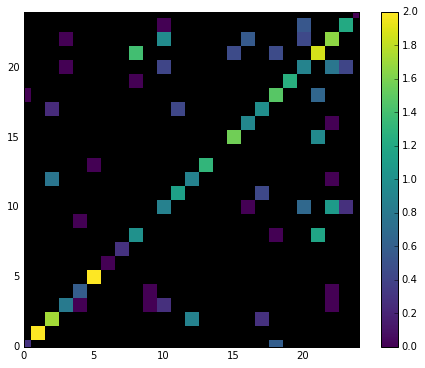

In [59]:
def show_trans_mat(M):
        
    plt.figure(figsize=(8,6))
    plt.imshow(np.log10(M.transition_matrix), cmap=cm.viridis, vmin=-5, vmax=-1, interpolation='nearest')
    #plt.imshow(np.log10(M.sample_mean('transition_matrix')), cmap=cm.viridis, vmin=-5, vmax=-1, interpolation='nearest')
    plt.gca().set_axis_bgcolor('k')
    plt.colorbar()
    plt.savefig('{}/trans_matrix_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)

    plt.figure(figsize=(8,6))
    plt.imshow(np.log10(M.count_matrix_active), cmap=cm.viridis, vmin=0, vmax=2, interpolation='nearest')
    plt.ylim(0,24)
    plt.xlim(0,24)
    plt.gca().set_axis_bgcolor('k')
    plt.colorbar()
    plt.savefig('{}/count_matrix_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)

    return

plt.close('all')
show_trans_mat(M)
#plt.show()


Spectral analysis
----

   i     eigenval          its        ratio
   2       0.9958       2.3505       2.4139
   3       0.9898       0.9737       1.4597
   4       0.9851       0.6671       1.7485
   5       0.9741       0.3815       1.0292
   6       0.9734       0.3707       1.5399
   7       0.9593       0.2407       1.8423
   8       0.9263       0.1307       1.1122
   9       0.9184       0.1175       1.0799
  10       0.9122       0.1088       1.9738
  11       0.8341       0.0551       1.1025
  12       0.8187       0.0500       1.1280
  13       0.7980       0.0443       1.0735
  14       0.7848       0.0413       1.5234
  15       0.6914       0.0271       1.1067
  16       0.6647       0.0245       1.3247
  17       0.5821       0.0185       1.2599
  18       0.5057       0.0147       1.1358
  19       0.4610       0.0129       1.0532


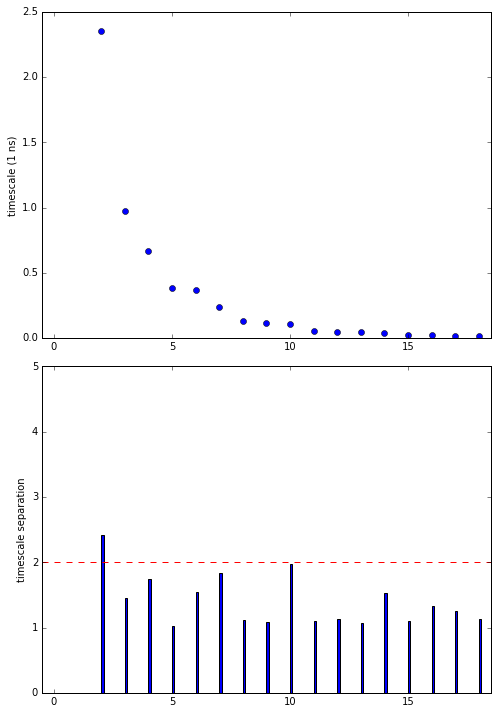

In [60]:
# Show eigenvalue separation

plt.close('all')

plt.figure(figsize=(7,10))
plt.subplot(211)
tmpy = dt * M.timescales()
tmpx = range(2, 2+len(tmpy))
plt.plot(tmpx, tmpy,linewidth=0,marker='o')
plt.ylabel('timescale (1 ns)'); 
plt.xlim(-0.5,18.5)
plt.ylim(0,min(10, plt.ylim()[1]))


plt.subplot(212)
tmpy_ = M.timescales()[:-1]/M.timescales()[1:]
tmpx_ = range(2, 2+len(tmpy_))
plt.bar(tmpx_, tmpy_, width=.1)#, linewidth=0,marker='o')
plt.axhline(2, c='r', ls='--')
plt.ylabel('timescale separation'); 
plt.xlim(-0.5,18.5)
plt.ylim(0, 5)

plt.tight_layout()
plt.savefig('{}/eigenval_separation_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)

print ('{:>4} {:>12} {:>12} {:>12}'.format('i', 'eigenval', 'its', 'ratio'))
for i in range(18):
    print ('{:4} {:>12.4f} {:>12.4f} {:>12.4f}'.format(i+2, M.eigenvalues()[i+1], dt*M.timescales()[i], M.timescales()[i]/M.timescales()[i+1]))


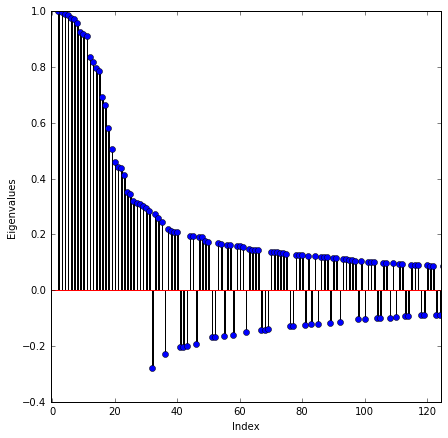

In [61]:
plt.close('all')

plt.figure(figsize=(7,7))
tmpy = M.eigenvalues()
tmpx = range(2, 2+len(tmpy))
plt.bar(tmpx, tmpy, width=.2)
plt.plot(tmpx, tmpy,linewidth=0,marker='o')
plt.axhline(0, c='r')
plt.ylabel('Eigenvalues'); 
plt.xlabel('Index'); 
plt.xlim(-0.5,124.5)
#plt.ylim(0,min(10, plt.ylim()[1]))

plt.savefig('{}/eigenvalues_clusters{}_lag{}.png'.format(activedir, n_clusters, msm_lag), dpi=144)


View eigenvectors
----

In [62]:
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=cm.viridis, cbar=True, 
                          cbar_label=None, vmin=None, vmax=None):
    # histogram data
    xmin = np.amin(xall)
    xmax = np.amax(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.amin(yall)
    ymax = np.amax(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    #eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = plt.gca()
    cf = ax.contourf(z.T, nlevels, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    if cbar:
        cbar = plt.colorbar(cf)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)
            
    return ax


def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=cm.viridis, cbar=True, cbar_label=None, vmin=None, vmax=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, 
                                 cbar=cbar, cbar_label=cbar_label, vmin=vmin, vmax=vmax)


/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


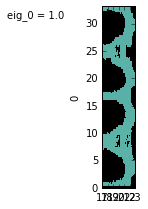

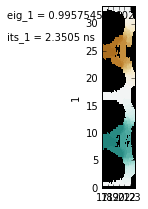

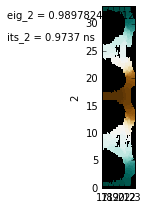

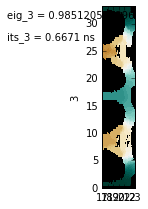

In [65]:
def show_eigenvec(first_n_ev):

    def proj_ev():
        proj_ev_all = []
        for i in range(min(32,n_clusters)):
            tmp_ = []
            xx = []
            yy = []
            eigval = M.eigenvalues()[i]
            eigvec = np.copy(M.eigenvectors_right()[:,i])
            eigvec = np.append(eigvec, 0)
            for dtraj_mapped in M.discrete_trajectories_active:  # loop over each discrete trajectory
                tmp_.append(eigvec[dtraj_mapped])
            proj_ev_all.append(np.hstack(tmp_))
        return proj_ev_all

    
    proj_ev_all = proj_ev()
    
    ncols = 4; nrows = int(np.ceil(first_n_ev / float(ncols)))
    plt.figure(figsize=(16,nrows*3))

    vmin=-2
    vmax=2

    for i in range(first_n_ev):
      if 1:
        plt.figure(figsize=(9,3))

      if 1:
        plt.subplot(1, 3, 1)
#        plot_sampled_function(tmp[:,0], tmp[:,1], np.vstack(proj_ev_all)[i], cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
        plot_sampled_function(np.vstack(Y)[:,0], np.vstack(Y)[:,1], proj_ev_all[i], cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
#        plot_sampled_function(tmp[:,0], tmp[:,1], (proj_ev_all), cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
        plt.gca().set_aspect('equal')
        plt.gca().set_axis_bgcolor('k')
        plt.ylabel(i)

      if 0:
        plt.subplot(1, 3, 2)
#        plot_sampled_function(tmp[:,0], tmp[:,2], np.vstack(proj_ev_all)[i], cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
        plot_sampled_function(np.vstack(Y)[:,0], np.vstack(Y)[:,2], proj_ev_all[i], cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
        plt.gca().set_aspect('equal')
        plt.gca().set_axis_bgcolor('k')

        plt.subplot(1, 3, 3)
        plot_sampled_function(np.vstack(Y)[:,1], np.vstack(Y)[:,2], proj_ev_all[i], cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
#        plot_sampled_function(tmp[:,1], tmp[:,2], np.vstack(proj_ev_all)[i], cbar=False, cmap='BrBG', vmin=vmin, vmax=vmax, nlevels=50)
        plt.gca().set_aspect('equal')
        plt.gca().set_axis_bgcolor('k')
      if 1:
        plt.figtext(0, .9, 'eig_{} = {}'.format(i, M.eigenvalues()[i]))
        if i>0:
            plt.figtext(0, .8, 'its_{} = {:.4f} ns'.format(i, dt*M.timescales()[i-1]))
        
        plt.tight_layout()
        plt.savefig('{}/eigenvec_lag{}_{:02d}.png'.format(activedir, msm_lag, i), dpi=144)
    return


plt.close('all')
show_eigenvec(4)

PCCA
----

In [66]:
# Number of desired macrostates
n_sets = 10
M.pcca(n_sets)

pcca_dist = np.copy(M.metastable_distributions)  # P(state | metastable)
pcca_dist = np.append(pcca_dist, np.zeros((n_sets,1)), axis=1)

membership = np.copy(M.metastable_memberships)  # P(metastable | state)
membership = np.append(membership, np.zeros((1,n_sets)), axis=0)

# memberships over trajectory
dist_all = [np.hstack([pcca_dist[i,:][dtraj_m] for dtraj_m in M.discrete_trajectories_active]) for i in range(n_sets)]
mem_all = [np.hstack([membership[:,i][dtraj_m] for dtraj_m in M.discrete_trajectories_active]) for i in range(n_sets)]

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


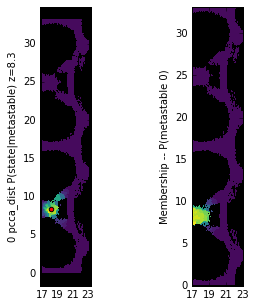

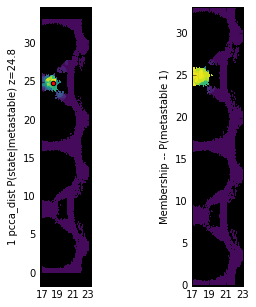

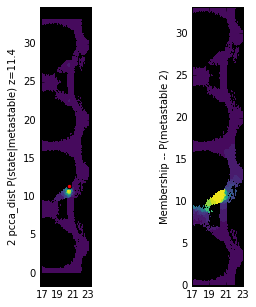

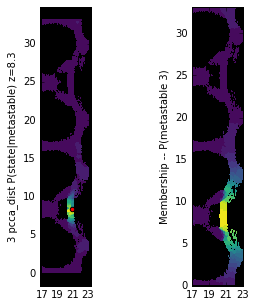

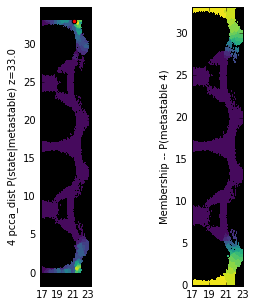

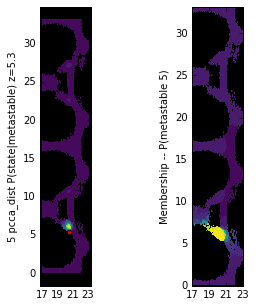

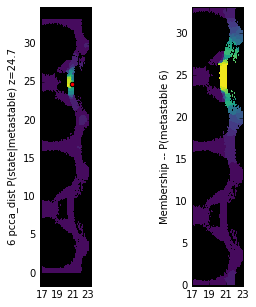

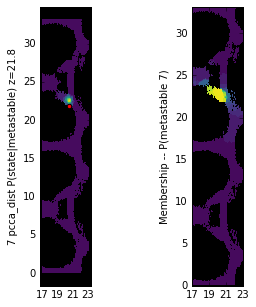

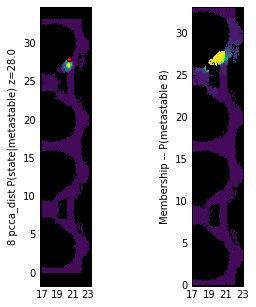

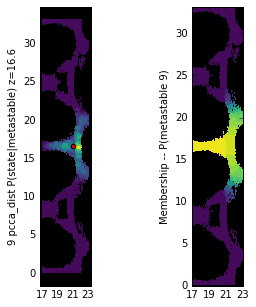

In [68]:
def show_pcca_dens():

    def get_centroid(clustercenters, weights):
        active = np.copy(M.active_set)
        sz = np.copy(clustercenters)
        sz = sz[active, :]
        
        fz = sz[:,1] / 16.58  # [0,2)
        fz_P = fz[np.argmax(weights)]  # fz value of highest probability

        fz_lower = fz_P - 1
        new_fz = (fz - fz_lower) % 2 + fz_lower
                
        new_z = new_fz * 16.58
        
        sz[:,1] = new_z

        sz_w = sz * weights[:,np.newaxis]
        
        max_sz = np.sum(sz_w, axis=0)
        return max_sz
    
    ncols = 3; nrows = int(np.ceil(n_sets*3 / float(ncols)))
    ncols=2; nrows=1
    plt.close('all')
    plt.rc('font', size=10)
    
    vmin = 0
    vmax = 100
        
    for i in range(n_sets):
      if 1:
        plt.figure(figsize=(5,5))
        
        # DIST
        plt.subplot(1, ncols, 3*0+1)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(np.vstack(Y)[:,0], np.vstack(Y)[:,1], dist_all[i], nbins=300, vmin=0, cmap=cm.viridis, cbar=False)
        scen, zcen = get_centroid(clustering.clustercenters, pcca_dist[i,0:-1])
        plt.scatter(scen, zcen, c='r')
        plt.ylabel('{} pcca_dist P(state|metastable) z={:.1f}'.format(i,zcen))
        plt.xticks([17, 19, 21, 23])

      if 1:
        # MEMB
        plt.subplot(1, ncols, 2)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(np.vstack(Y)[:,0], np.vstack(Y)[:,1], mem_all[i], nbins=300, vmin=0, cmap=cm.viridis, cbar=False)
        #plt.scatter(*get_centroid(clustering.clustercenters, pcca_dist[i,0:-1]), c='r')
        plt.ylabel('Membership -- P(metastable {})'.format(i))
        plt.xticks([17, 19, 21, 23])
      if 1:
        plt.savefig('{}/eig_dens_lag{}_nsets{}_{:02d}.png'.format(activedir, msm_lag, n_sets, i), dpi=144)
    return
    

#show_pcca_dens(np.swapaxes(Y,0,1))
show_pcca_dens()


Chapman-Kolmogorov test
----

In [69]:

ck = M.cktest(n_sets, mlags=4, err_est=False)

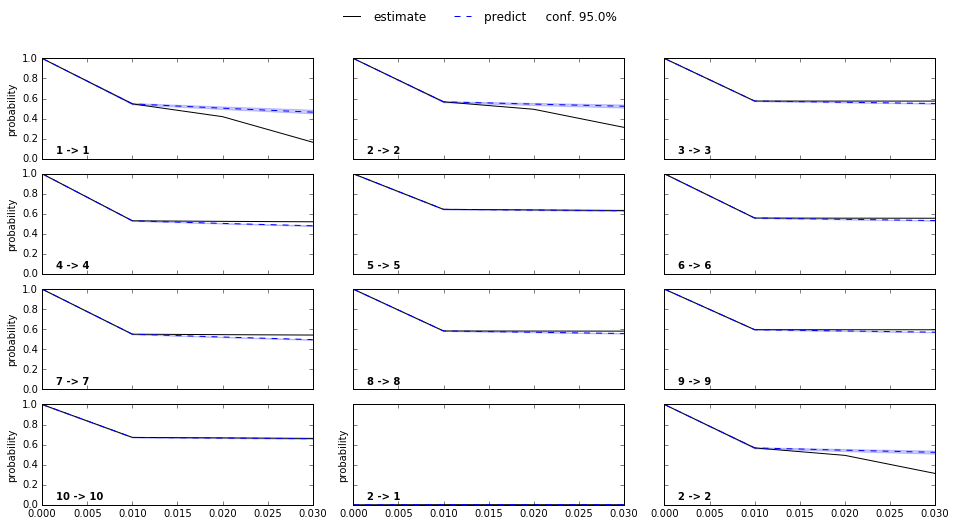

In [70]:
try:
    plt.close('all')
    plt.figure()
    mplt.plot_cktest(ck, diag=True, figsize=(16,8), layout=(4, 3), 
                 padding_top=0.1, y01=True, padding_between=0.15, dt=.001, units='ns')
    plt.savefig('{}/cktest_nclust{}_lag{}_nsets{}.png'.format(activedir, n_clusters, msm_lag, n_sets), dpi=144)
except:
    print "Figure not created"
    pass

Coarse-grained kinetic Model using a Hidden Markov Model
------

Now we want a coarse-grained kinetic model between these four metastable states. Coarse-graining of Markov models has been investigated by a number of researchers, so different approaches exist. It is certainly a bad a idea to just bin the clusters into four groups, e.g. using the PCCA memberships, and then re-estimate an MSM on these four states. This is going to be a very poor MSM, most likely it will not get timescales anywhere near those seen above and fail the CK-Test.

We recommend the following approach: Use the MSM and the metastable states computed by PCCA in order to estimate a four-state HMM. This can be simply achieved by calling coarse-grain on the MSM:

In [71]:
# Hidden Markov Model
hmm = M.coarse_grain(n_sets)

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


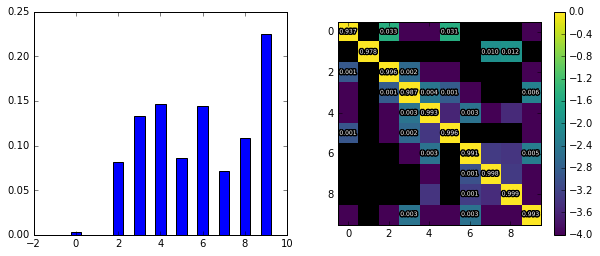

In [72]:
import matplotlib.patheffects as path_effects

# View stationary distribution of states

plt.close('all')
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.bar([i-.25 for i in range(n_sets)], hmm.stationary_distribution, width=.5)

# View transition matrix
plt.subplot(122)
plt.imshow(np.log10(hmm.transition_matrix), cmap=cm.viridis, vmin=-4, vmax=0, interpolation='nearest')
plt.gca().set_axis_bgcolor('k')
# Label with values
for i in range(n_sets):
    for j in range(n_sets):
        #print j,i,hmm.transition_matrix[j,i]
        if hmm.transition_matrix[j,i]>5e-4:
            val = '{:.3f}'.format(hmm.transition_matrix[j,i])
            text = plt.gca().text(i,j, val, color='white', ha='center', va='center', size=60//n_sets)
            text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])

plt.colorbar()

plt.savefig('{}/pcca_clusters{}_lag{}_nsets{}.png'.format(activedir, n_clusters, msm_lag, n_sets), dpi=144)

In [73]:
A, B = [3], [5]
#A, B = [4], [9]
A,B = [0,2,3,5], [1, 6, 7, 8]


tpt = msm.tpt(hmm, A,B)

print ('**forward committor**: ')
print (tpt.committor)

#print ('Gross TPT flux = ', tpt.gross_flux)
#print ('Net TPT flux = ', tpt.net_flux)
print ('')
print ('Total TPT flux = ', tpt.total_flux)
print ('Round trip time = ', msm_lag/tpt.total_flux)

#print ('Rate from TPT flux = ', tpt.rate)\
print ('')
print ('A->B transition time = ', msm_lag/tpt.rate)
print ('B->A transition time = ', msm_lag/msm.tpt(hmm, B,A).rate)
print ('Round trip time = ', msm_lag/msm.tpt(hmm, A,B).rate+msm_lag/msm.tpt(hmm, B,A).rate)

print ('')
print ('mfpt(A,B) = ', hmm.mfpt(A,B))
print ('mfpt(B,A) = ', hmm.mfpt(B,A))
print ('Round trip time = {}'.format(np.sum((hmm.mfpt(B, A), hmm.mfpt(A,B)))))

oneway = msm_lag/tpt.total_flux/2
oneway_ = np.sum((hmm.mfpt(B, A), hmm.mfpt(A,B)))/2

**forward committor**: 
[ 0.          1.          0.          0.          0.48066496  0.          1.
  1.          1.          0.48380356]

('Total TPT flux = ', 0.00064029065648358934)
('Round trip time = ', 15617.907115682392)

('A->B transition time = ', 7753.3565960115875)
('B->A transition time = ', 7864.5505196717522)
('Round trip time = ', 15617.90711568334)

('mfpt(A,B) = ', 9814.0262117143757)
('mfpt(B,A) = ', 12868.802464508764)
Round trip time = 22682.8286762


In [74]:
estD = 0.5*16.58**2/oneway * 1e-8  # m2/s
estD_ = 0.5*16.58**2/oneway_ * 1e-8  # m2/s
print (estD,estD_)

(1.7601359642097535e-10, 1.2119141043822067e-10)



**Gross flux illustration**: 

**Net flux illustration**: 

**Net percentage flux illustration**: 


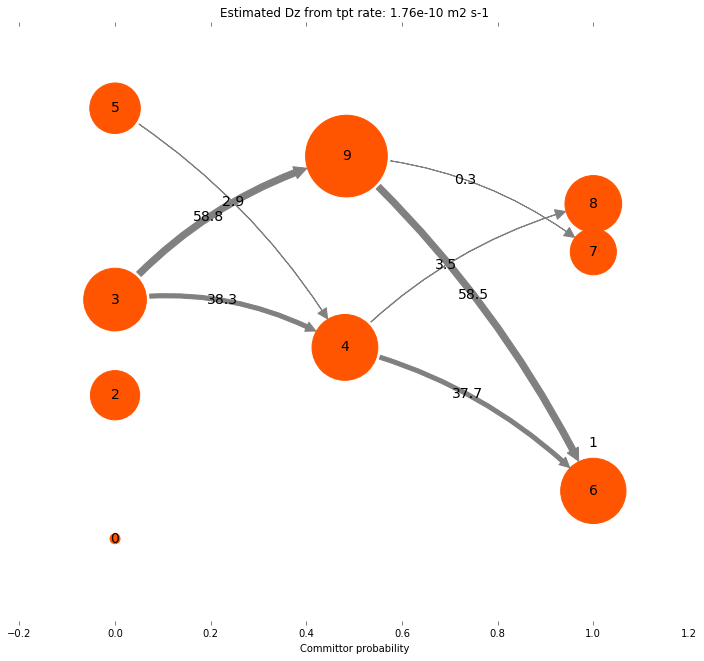

In [75]:
# we position states along the y-axis according to the commitor
tptpos = np.array([tpt.committor, [
                                   .0, # 0
                                   .2, # 1
                                   .3, # 2
                                   .5, # 3
                                   .4, # 4
                                   .9, # 5
                                   .1, # 6
                                   .6, # 7
                                   .7, # 8
                                   .8, # 9
                               #    0, # 10
                               #    0, # 11
                               #    0 # 12
                                  ]]).transpose()

tptpos =  np.array([tpt.committor, 1.0*np.arange(n_sets)[np.argsort(tpt.committor)]/n_sets]).transpose()
#print (tptpos)

minflux = 1e-7

plt.close('all')
print ('\n**Gross flux illustration**: ')
#mplt.plot_flux(tpt, pos=tptpos, arrow_label_format="%10.1e", attribute_to_plot='gross_flux', minflux=1e-5)
mplt.plot_flux(tpt, pos=tptpos, arrow_label_format="%10.2e", attribute_to_plot='gross_flux', minflux=minflux, fontsize=44)
plt.savefig('{}/tpt_gross_flux_clusters{}_lag{}_A{}_B{}.png'.format(activedir, n_clusters, msm_lag, A, B), dpi=144)

plt.close('all')
print ('\n**Net flux illustration**: ')
mplt.plot_flux(tpt, pos=tptpos, arrow_label_format="%10.2e", attribute_to_plot='net_flux', minflux=minflux, fontsize=44)
plt.savefig('{}/tpt_net_flux_clusters{}_lag{}_A{}_B{}.png'.format(activedir, n_clusters, msm_lag, A, B), dpi=144)

plt.close('all')
print ('\n**Net percentage flux illustration**: ')
mplt.plot_flux(tpt, pos=tptpos, flux_scale=100.0/tpt.total_flux, arrow_label_format="%3.1f", minflux=minflux, fontsize=44)
plt.title('Estimated Dz from tpt rate: {:.2e} m2 s-1'.format(estD))
plt.savefig('{}/tpt_pct_flux_clusters{}_lag{}_A{}_B{}.png'.format(activedir, n_clusters, msm_lag, A, B), dpi=144)
